In [ ]:
# ============================================
# FULL SENTIMENT TRAINING PIPELINE (FAST MODE)
# ============================================

!pip install transformers datasets evaluate accelerate sentencepiece -q

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate
import os

# ======================================================
# 1) LOAD PARQUET FILES
# ======================================================
train_df = pd.read_parquet("/content/train-00000-of-00001.parquet")
val_df   = pd.read_parquet("/content/validation-00000-of-00001.parquet")
test_df  = pd.read_parquet("/content/test-00000-of-00001.parquet")

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
})

print("Original dataset sizes:", dataset)

# ======================================================
# 2) REDUCE DATASET FOR FAST TRAINING
# ======================================================
dataset["train"] = dataset["train"].select(range(min(20000, len(dataset["train"]))))
dataset["validation"] = dataset["validation"].select(range(min(5000, len(dataset["validation"]))))
dataset["test"] = dataset["test"].select(range(min(5000, len(dataset["test"]))))

print("Reduced dataset sizes:", dataset)

# ======================================================
# 3) LOAD TOKENIZER
# ======================================================
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ======================================================
# 4) TOKENIZATION FUNCTION
# ======================================================
def tokenize(batch):
    return tokenizer(
        batch["review"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization
tokenized_dataset = dataset.map(tokenize, batched=True)

# ======================================================
# 5) LOAD MODEL
# ======================================================
num_labels = len(set(train_df["label"]))

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# ======================================================
# 6) METRICS
# ======================================================
metric_acc  = evaluate.load("accuracy")
metric_f1   = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec  = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy":  metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1":        metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": metric_prec.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall":    metric_rec.compute(predictions=preds, references=labels, average="weighted")["recall"]
    }

# ======================================================
# 7) TRAINING ARGUMENTS (OPTIMIZED FOR SPEED)
# ======================================================
training_args = TrainingArguments(
    output_dir="/content/sentiment_model",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=50,
    fp16=True,
    report_to=[]
)

# ======================================================
# 8) TRAINER
# ======================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Disable W&B logs
os.environ["WANDB_DISABLED"] = "true"

# ======================================================
# 9) TRAIN
# ======================================================
trainer.train()

# ======================================================
# 10) FINAL EVALUATION
# ======================================================
print("\nFinal Evaluation:")
print(trainer.evaluate(tokenized_dataset["test"]))


Original dataset sizes: DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})
Reduced dataset sizes: DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-1178600097.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.639200
100,0.474400
150,0.383700
200,0.327900
250,0.335200
300,0.278200
350,0.307000
400,0.292800
450,0.299200
500,0.288700



Final Evaluation:


{'eval_loss': 0.2991790175437927, 'eval_accuracy': 0.9106, 'eval_f1': 0.910627559793734, 'eval_precision': 0.9107898853808001, 'eval_recall': 0.9106, 'eval_runtime': 9.3858, 'eval_samples_per_second': 532.719, 'eval_steps_per_second': 16.727, 'epoch': 3.0}



Accuracy:  0.9106
Precision: 0.9108
Recall:    0.9106
F1 Score:  0.9106

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2611
           1       0.90      0.92      0.91      2389

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000


===== CONFUSION MATRIX =====
[[2366  245]
 [ 202 2187]]


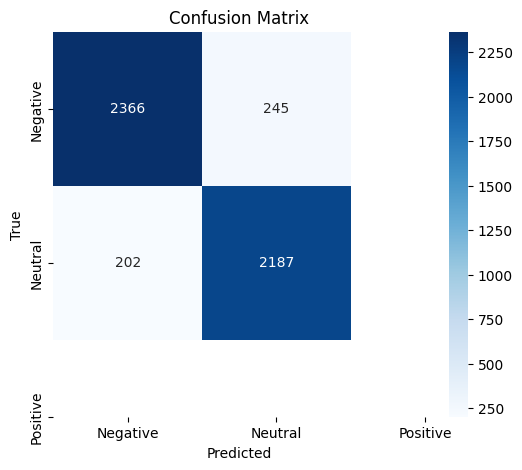

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# =============================
# 1. GET PREDICTIONS
# =============================
pred_output = trainer.predict(tokenized_dataset["test"])

logits = pred_output.predictions
labels = pred_output.label_ids
preds = torch.argmax(torch.tensor(logits), dim=1)

# =============================
# 2. BASIC METRICS
# =============================
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =============================
# 3. FULL CLASSIFICATION REPORT
# =============================
print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(labels, preds))

# =============================
# 4. CONFUSION MATRIX
# =============================
cm = confusion_matrix(labels, preds)
print("\n===== CONFUSION MATRIX =====")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch

# --------------------------------------------
# 1. LABEL → NUMBER MAPPING
# change according to your dataset if needed
# For example, if your labels are:
# 0 = negative → rating 1
# 1 = neutral  → rating 3
# 2 = positive → rating 5
# --------------------------------------------
label_to_rating = {
    0: 1,
    1: 3,
}

# --------------------------------------------
# 2. PREDICTION FUNCTION
# --------------------------------------------
def predict_rating(text):
    encoded = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**encoded)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()

    rating = label_to_rating[pred_label]
    return pred_label, rating

# --------------------------------------------
# 3. TAKE USER INPUT
# --------------------------------------------
user_text = input("Enter your movie review: ")

pred_label, rating = predict_rating(user_text)

print("Predicted Label:", pred_label)

Enter your movie review: Tout s’est déroulé parfaitement.
Predicted Label: 1


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/distilmb_model",

    # No eval/save/log strategy allowed in your version.
    # No load_best_model_at_end allowed either.

    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,

    # These still work fine:
    logging_steps=50,
    eval_steps=500,
    save_steps=500,

    save_total_limit=2
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# ============================================================
# 1. INSTALL DEPENDENCIES
# ============================================================
!pip install -U transformers datasets accelerate --quiet
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# ============================================================
# 2. IMPORTS
# ============================================================
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np

# ============================================================
# 3. LOAD DATA (YOUR FILE PATHS)
# ============================================================
train_df = pd.read_parquet("/content/train-00000-of-00001.parquet")
valid_df = pd.read_parquet("/content/validation-00000-of-00001.parquet")
test_df  = pd.read_parquet("/content/test-00000-of-00001.parquet")

print("Train:", train_df.head())
print("Columns:", train_df.columns)

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds  = Dataset.from_pandas(test_df)

# ============================================================
# 4. TOKENIZER
# ============================================================
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["review"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_tok = train_ds.map(tokenize, batched=True)
valid_tok = valid_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

train_tok = train_tok.remove_columns(["review"]).rename_column("label", "labels")
valid_tok = valid_tok.remove_columns(["review"]).rename_column("label", "labels")
test_tok  = test_tok.remove_columns(["review"]).rename_column("label", "labels")

train_tok.set_format("torch")
valid_tok.set_format("torch")
test_tok.set_format("torch")

# ============================================================
# 5. MODEL
# ============================================================
num_labels = len(set(train_df["label"]))

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# ============================================================
# 6. METRICS
# ============================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": (preds == labels).mean()}

# ============================================================
# 7. TRAINING ARGS FOR YOUR TRANSFORMERS VERSION
# ============================================================
training_args = TrainingArguments(
    output_dir="/content/distilmb_model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# ============================================================
# 8. TRAINER
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ============================================================
# 9. TRAIN
# ============================================================
trainer.train()

# ============================================================
# 10. FINAL EVALUATION
# ============================================================
print("\nFinal Test Accuracy:")
trainer.evaluate(test_tok)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.9 MB/s eta 0:00:00
Train:                                               review  label
0  Si vous cherchez du cinéma abrutissant à tous ...      0
1  Trash, re-trash et re-re-trash...! Une horreur...      0
2  Et si, dans les 5 premières minutes du film, l...      0
3  Mon dieu ! Quelle métaphore filée ! Je suis ab...      0
4  Premier film de la saga Kozure Okami, "Le Sabr...      1
Columns: Index(['review', 'label'], dtype='object')


tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/distiluse-base-multilingual-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-643176651.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.234200,0.201084,0.922450



Final Test Accuracy:


{'eval_loss': 0.19628693163394928,
 'eval_accuracy': 0.92505,
 'eval_runtime': 20.9737,
 'eval_samples_per_second': 953.574,
 'eval_steps_per_second': 59.598,
 'epoch': 1.0}

In [ ]:
from datasets import Dataset

# rename the column so tokenizer works
df = df.rename(columns={"review": "text"})

# ensure label is int
df["label"] = df["label"].astype(int)

# convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# tokenize
dataset = dataset.map(tokenize, batched=True)

# remove old columns
dataset = dataset.remove_columns(["text"])
dataset = dataset.with_format("torch")


NameError: name 'df' is not defined

In [ ]:
# ============================================
# 1. INSTALL + IMPORTS
# ============================================
!pip install transformers datasets accelerate

from datasets import Dataset
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate

# ============================================
# 2. LOAD PARQUET FILES
# ============================================
train_df = pd.read_parquet("train-00000-of-00001.parquet")
valid_df = pd.read_parquet("validation-00000-of-00001.parquet")
test_df  = pd.read_parquet("test-00000-of-00001.parquet")

train_df = train_df.rename(columns={"review": "text"})
valid_df = valid_df.rename(columns={"review": "text"})
test_df  = test_df.rename(columns={"review": "text"})

# ============================================
# 3. CREATE HF DATASETS
# ============================================
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds  = Dataset.from_pandas(test_df)

# ============================================
# 4. TOKENIZER
# ============================================
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
valid_ds = valid_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# Remove ONLY "text"
train_ds = train_ds.remove_columns(["text"])
valid_ds = valid_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

train_ds = train_ds.with_format("torch")
valid_ds = valid_ds.with_format("torch")
test_ds  = test_ds.with_format("torch")

# ============================================
# 5. MODEL
# ============================================
num_labels = len(train_df["label"].unique())

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# ============================================
# 6. TRAINING ARGUMENTS (OLD VERSION SAFE)
# ============================================
training_args = TrainingArguments(
    output_dir="xlmr_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=50,
    save_steps=200
)

# ============================================
# 7. METRICS
# ============================================
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return accuracy.compute(predictions=predictions, references=labels)

# ============================================
# 8. TRAINER
# ============================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ============================================
# 9. TRAIN
# ============================================
trainer.train()

# ============================================
# 10. TEST
# ============================================
print("\nFinal Test Accuracy:")
trainer.evaluate(test_ds)


In [ ]:
from datasets import load_dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import torch

# =====================================================
# LOAD DATASET (Your parquet files)
# =====================================================
dataset = load_dataset(
    "parquet",
    data_files={
        "train": "train-00000-of-00001.parquet",
        "validation": "validation-00000-of-00001.parquet",
        "test": "test-00000-of-00001.parquet"
    }
)

# Limit train set to 5000 rows
dataset["train"] = dataset["train"].select(range(min(5000, len(dataset["train"]))))

# =====================================================
# TOKENIZER & MODEL
# =====================================================
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["review"],        # <-- FIXED COLUMN NAME
        truncation=True,
        padding=True,
        max_length=128
    )

# remove only columns that exist: "review" and "label"
tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["review"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

# =====================================================
# TRAINING ARGS
# =====================================================
training_args = TrainingArguments(
    output_dir="xlmr_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    fp16=True,
    report_to="none"
)

# =====================================================
# TRAINER
# =====================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

# =====================================================
# SAVE FINAL MODEL
# =====================================================
trainer.save_model("xlmr_model_final")
tokenizer.save_pretrained("xlmr_model_final")


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_with_metrics(trainer, dataset):
    print("Running evaluation...")

    trainer.model.eval()

    preds = []
    labels = []

    for batch in dataset:
        if "input_ids" not in batch:
            print("❌ ERROR: Dataset not tokenized — no input_ids found")
            return

        inputs = {
            "input_ids": torch.tensor(batch["input_ids"]).unsqueeze(0).to(trainer.model.device),
            "attention_mask": torch.tensor(batch["attention_mask"]).unsqueeze(0).to(trainer.model.device),
        }

        with torch.no_grad():
            outputs = trainer.model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()

        preds.append(pred)
        labels.append(batch["label"])

    if len(labels) == 0:
        print("❌ Validation dataset is EMPTY")
        return

    # ---- METRICS ----
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    print("Samples evaluated:", len(labels))
    print("----------------------------------")
    print("Accuracy :", accuracy)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1 Score :", f1)
    print("----------------------------------")
evaluate_with_metrics(trainer, tokenized_dataset["validation"])


In [ ]:
!zip -r xlmr_model_final.zip xlmr_model_final


In [ ]:
# ==========================================================
# XLM-R Evaluation (Single Working Block)
# ==========================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

true_labels = []
pred_labels = []

model.eval()

# ------------------ RUN PREDICTIONS -----------------------
for batch in dataset["validation"]:
    # Tokenize each review
    encoded = tokenizer(
        batch["review"],          # <-- Your column name
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**encoded)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    pred_labels.extend(preds)
    true_labels.append(batch["label"])    # <-- label column

# ------------------ METRICS -------------------------------

print("Accuracy:", accuracy_score(true_labels, pred_labels))

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))

# ------------------ CONFUSION MATRIX -----------------------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
